In [ ]:
"""
CS410 FA25 Group 18 Final Project

Install dependencies and make sure dataset exists
"""
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm -q

import os
os.makedirs('data', exist_ok=True)

# Set to True to load pre-trained models and skip training
LOAD_FROM_FILES = True

print(f"LOAD_FROM_FILES = {LOAD_FROM_FILES}")

LOAD_FROM_FILES = True


In [6]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import math

from tqdm import tqdm
from nltk.corpus import stopwords
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
from collections import Counter

nltk.download('stopwords', quiet=True)

# global settings
STOPWORDS = set(stopwords.words('english'))
KEEP_WORDS = {'not', 'no', 'never', 'without', 'none'}
STOPWORDS = STOPWORDS - KEEP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["parser"])

# preprocessing helpers
def clean_text(text, preserve_entities=True):
    text = str(text).lower()
    text = re.sub(r'[\\,<>./?@#$%^&*_~!()\-=\[\]{};:\'\"\|`0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    doc = nlp(text)
    tokens = []
    for token in doc:
        if preserve_entities and token.ent_type_:
            tokens.append(token.text)
        elif token.lemma_ not in STOPWORDS and len(token.text) > 2:
            tokens.append(token.lemma_)
    return " ".join(tokens)

def normalize_title(t):
    return re.sub(r'[^a-z0-9\s]', '', str(t).lower().strip())

# load dataset from data directory
df = pd.read_csv("data/imdb_movie_keyword.csv")
print(f"Loaded {len(df)} movies")
df.head()

Loaded 9746 movies


,movie_title,year,genre,synopsis,cast,Key-Bert,Yake,Sentence_transformers
0,A Splash of Love,2022,"Comedy, Romance, Back to top","Chloe Turner, a Ph.D. candidate in Marine Mamm...","Heather Hawthorn Doyle (dir.), Rhiannon Fish, ...","['whale', 'miami', 'fish', 'pacific', 'marine']","['Miami Central College', 'Central College', '...","['chloe', 'turner', 'help', 'northwest', 'loca..."
1,The Grey Man,2007,"Biography, Crime, Drama, Back to top",Kevin Dodds is a browbeaten deputy bank manage...,"Declan O'Dwyer (dir.), Daniel Ryan, Nitin Ganatra","['rob', 'manager', 'bank', 'novel', 'devises']","['Kevin Dodds', 'browbeaten deputy bank', 'dep...","['bank', 'mcnab']"
2,Descendants,2015,"Comedy, Family, Fantasy, Back to top","Ben, son of Belle and the once selfish Beast, ...","Kenny Ortega (dir.), Dove Cameron, Cameron Boyce","['son', 'selfish', 'villain', 'beast', 'lost']","['attend Auradon Prep', 'Auradon Prep', 'son o...",['ben']
3,Teen Wolf: The Movie,n,"Action, Comedy, Drama, Back to top","A full moon rises in Beacon Hills, and with it...","Russell Mulcahy (dir.), Melissa Ponzio, Linden...","['werewolf', 'wolves', 'howling', 'deadliest',...","['full moon rises', 'Beacon Hills', 'rises in ...","['moon rises', 'trusted', 'werecoyotes']"
4,High School Musical,2006,"Comedy, Drama, Family, Back to top",Troy Bolton and Gabriella Montez are two total...,"Kenny Ortega (dir.), Zac Efron, Vanessa Hudgens","['decathlon', 'karaoke', 'mexico', 'party', 'a...","['Year Eve', 'Gabriella Montez', 'Troy Bolton'...","['troy', 'gabriella', 'hate', 'bolton', 'week'..."


In [7]:
# Process each field separately for BM25F-style scoring
df['plot_clean'] = df['synopsis'].apply(lambda x: clean_text(str(x)))
df['keywords_clean'] = df.apply(
    lambda r: clean_text(f"{r.get('Key-Bert', '')} {r.get('Yake', '')} {r.get('Sentence_transformers', '')}"), 
    axis=1
)
df['meta_clean'] = df.apply(
    lambda r: clean_text(f"{r.get('genre', '')} {r.get('year', '')}"), 
    axis=1
)

# Combined text for semantic embeddings
df['full_text'] = df['plot_clean'] + ' ' + df['keywords_clean'] + ' ' + df['meta_clean']

# Tokenized corpussss for each field
corpus_plot = [doc.split() for doc in df['plot_clean']]
corpus_keywords = [doc.split() for doc in df['keywords_clean']]
corpus_meta = [doc.split() for doc in df['meta_clean']]
corpus_full = [doc.split() for doc in df['full_text']]

print(f"Preprocessing complete. Sample plot: {df['plot_clean'].iloc[0][:100]}...")

Preprocessing complete. Sample plot: chloe turner candidate marine mammalogy miami central college get opportunity one week research proj...


In [8]:
# Build BM25 indices and semantic model
import pickle

print("Building BM25 indices...")
bm25_plot = BM25Okapi(corpus_plot, k1=1.2, b=0.75)
bm25_keywords = BM25Okapi(corpus_keywords, k1=1.2, b=0.75)
bm25_meta = BM25Okapi(corpus_meta, k1=1.2, b=0.75)
bm25_full = BM25Okapi(corpus_full, k1=1.2, b=0.75)

print("Loading semantic model...")
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

if LOAD_FROM_FILES:
    print("Loading embeddings from file...")
    embeddings = torch.load('models/embeddings.pt')
else:
    print("Computing embeddings...")
    embeddings = semantic_model.encode(df['full_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)

print(f"Embeddings shape: {embeddings.shape}")

Building BM25 indices...
Loading semantic model...
Loading embeddings from file...
Embeddings shape: torch.Size([9746, 384])


In [9]:
# BM25F-style scoring with field weights
def bm25f_score(query, w_plot=0.6, w_kw=0.3, w_meta=0.1):
    """Compute weighted BM25 scores across fields."""
    q_tokens = clean_text(query).split()
    scores_plot = bm25_plot.get_scores(q_tokens)
    scores_kw = bm25_keywords.get_scores(q_tokens)
    scores_meta = bm25_meta.get_scores(q_tokens)
    return w_plot * scores_plot + w_kw * scores_kw + w_meta * scores_meta

def get_top_k_bm25(query, top_k=200):
    """Stage 1: BM25F retrieval."""
    scores = bm25f_score(query)
    top_idx = np.argsort(scores)[::-1][:top_k].copy()
    return top_idx, scores[top_idx]

In [10]:
# Pseudo-Relevance Feedback (PRF)
def compute_idf(corpus):
    """Compute IDF for PRF term expansion."""
    N = len(corpus)
    df_counts = Counter()
    for doc in corpus:
        df_counts.update(set(doc))
    return {term: math.log((N + 1) / (count + 1)) for term, count in df_counts.items()}

if LOAD_FROM_FILES:
    print("Loading IDF scores from file...")
    with open('models/idf_scores.pkl', 'rb') as f:
        idf_scores = pickle.load(f)
else:
    print("Computing IDF scores...")
    idf_scores = compute_idf(corpus_full)

print(f"IDF scores loaded: {len(idf_scores)} terms")

def expand_query_prf(query, top_docs_idx, n_terms=10, prf_weight=0.3):
    """Expand query using pseudo-relevance feedback."""
    term_scores = Counter()
    for idx in top_docs_idx:
        doc_terms = corpus_full[idx]
        tf = Counter(doc_terms)
        for term, count in tf.items():
            if term in idf_scores:
                term_scores[term] += count * idf_scores[term]
    
    original_terms = set(clean_text(query).split())
    expansion_terms = [t for t, _ in term_scores.most_common(n_terms + len(original_terms)) 
                      if t not in original_terms][:n_terms]
    
    expanded = clean_text(query) + ' ' + ' '.join([f"{t}" for t in expansion_terms])
    return expanded

Loading IDF scores from file...
IDF scores loaded: 28024 terms


In [11]:
# Two-Stage Hybrid Search
def normalize_scores(scores):
    """Min-max normalize scores."""
    min_s, max_s = scores.min(), scores.max()
    if max_s - min_s < 1e-9:
        return np.zeros_like(scores)
    return (scores - min_s) / (max_s - min_s)

def two_stage_search(query, alpha=0.65, stage1_k=200, top_k=10, use_prf=True, prf_docs=10):
    """
    Two-stage retrieval:
    Stage 1: BM25F retrieves top-K candidates
    Stage 2: Semantic reranking on candidates
    """
    q_clean = clean_text(query)
    
    if use_prf:
        initial_idx, _ = get_top_k_bm25(query, top_k=prf_docs)
        q_expanded = expand_query_prf(query, initial_idx)
    else:
        q_expanded = q_clean
    
    # BM25F scoring
    bm25_scores = bm25f_score(q_expanded if use_prf else query)
    candidate_idx = np.argsort(bm25_scores)[::-1][:stage1_k].copy()
    
    # Stage 2: Semantic reranking on candidates only
    candidate_embeddings = embeddings[candidate_idx]
    q_emb = semantic_model.encode(q_clean, convert_to_tensor=True)
    sem_scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()
    
    # Normalize and combine
    bm25_norm = normalize_scores(bm25_scores[candidate_idx])
    sem_norm = normalize_scores(sem_scores)
    hybrid_scores = alpha * sem_norm + (1 - alpha) * bm25_norm
    
    # Get top-k from candidates
    top_in_candidates = np.argsort(hybrid_scores)[::-1][:top_k].copy()
    final_idx = candidate_idx[top_in_candidates]
    final_scores = hybrid_scores[top_in_candidates]
    
    return final_idx, final_scores

In [30]:
import json

# load test queries for tuning
with open('test_queries.json', 'r') as f:
    test_queries = json.load(f)

print(test_queries)

[{'query': 'movie where a marine biology student falls for a whale-watching tour guide', 'relevant': {'A Splash of Love': 2}}, {'query': 'action thriller about a CIA assassin hunted by a psychopathic former agent', 'relevant': {'The Grey Man': 2}}, {'query': 'kids of famous Disney villains go to a prep school with heroesâ€™ children', 'relevant': {'Descendants': 2}}, {'query': 'adult Scott McCall reunites with his pack to fight a new supernatural evil', 'relevant': {'Teen Wolf: The Movie': 2}}, {'query': 'teenagers audition for a school musical while balancing sports and friendships', 'relevant': {'High School Musical': 2}}, {'query': 'woman reunites with the naval officer she once rejected years earlier', 'relevant': {'Persuasion': 2}}, {'query': 'cheerleader falls for a zombie boy in a school divided by humans and zombies', 'relevant': {'Z-O-M-B-I-E-S': 2}}, {'query': 'woman starts receiving mysterious romantic letters that change her life', 'relevant': {'14 Love Letters': 2}}, {'que

In [31]:
# Hyperparameter tuning for best ndcg@10
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Evaluation metrics
def precision_at_k(relevance, k=10):
    """Calculate precision@k from relevance scores."""
    relevance = np.asarray(relevance)[:k]
    return np.sum(relevance > 0) / k

def ndcg_at_k(relevance, k=10):
    """Calculate nDCG@k from relevance scores."""
    relevance = np.asarray(relevance)[:k]
    dcg = np.sum(relevance / np.log2(np.arange(2, len(relevance) + 2)))
    ideal = np.sum(sorted(relevance, reverse=True) / np.log2(np.arange(2, len(relevance) + 2)))
    return dcg / ideal if ideal > 0 else 0

def get_relevance_scores(retrieved_idx, relevant_dict):
    """Get relevance scores for retrieved documents."""
    rel_normalized = {normalize_title(k): v for k, v in relevant_dict.items()}
    scores = []
    for idx in retrieved_idx:
        title = normalize_title(df.iloc[idx]['movie_title'])
        scores.append(rel_normalized.get(title, 0))
    return scores

# Define search function with configurable parameters
def search_with_params(query, alpha, w_plot, w_kw, w_meta, stage1_k=200, top_k=10, use_prf=True, prf_docs=10):
    """Search with configurable hyperparameters."""
    q_clean = clean_text(query)
    q_tokens = q_clean.split()
    
    # BM25F scoring with custom weights
    scores_plot = bm25_plot.get_scores(q_tokens)
    scores_kw = bm25_keywords.get_scores(q_tokens)
    scores_meta = bm25_meta.get_scores(q_tokens)
    bm25_scores = w_plot * scores_plot + w_kw * scores_kw + w_meta * scores_meta
    
    if use_prf:
        initial_idx = np.argsort(bm25_scores)[::-1][:prf_docs].copy()
        q_expanded = expand_query_prf(query, initial_idx)
        q_tokens_expanded = q_expanded.split()
        scores_plot = bm25_plot.get_scores(q_tokens_expanded)
        scores_kw = bm25_keywords.get_scores(q_tokens_expanded)
        scores_meta = bm25_meta.get_scores(q_tokens_expanded)
        bm25_scores = w_plot * scores_plot + w_kw * scores_kw + w_meta * scores_meta
    
    candidate_idx = np.argsort(bm25_scores)[::-1][:stage1_k].copy()
    
    # Semantic reranking
    candidate_embeddings = embeddings[candidate_idx]
    q_emb = semantic_model.encode(q_clean, convert_to_tensor=True)
    sem_scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()
    
    bm25_norm = normalize_scores(bm25_scores[candidate_idx])
    sem_norm = normalize_scores(sem_scores)
    hybrid_scores = alpha * sem_norm + (1 - alpha) * bm25_norm
    
    top_in_candidates = np.argsort(hybrid_scores)[::-1][:top_k].copy()
    return candidate_idx[top_in_candidates], hybrid_scores[top_in_candidates]

if LOAD_FROM_FILES:
    # Load tuned parameters from saved config
    print("Loading tuned parameters from file...")
    with open('models/model_config.pkl', 'rb') as f:
        model_config = pickle.load(f)
    
    tuned_alpha = model_config['alpha']
    tuned_w_plot = model_config['w_plot']
    tuned_w_kw = model_config['w_kw']
    tuned_w_meta = model_config['w_meta']
    
    print(f"Loaded parameters: alpha={tuned_alpha:.4f}, w_plot={tuned_w_plot:.4f}, w_kw={tuned_w_kw:.4f}, w_meta={tuned_w_meta:.4f}")
else:
    # Optuna objective function
    def objective(trial):
        alpha = trial.suggest_float('alpha', 0.4, 0.9)
        w_plot = trial.suggest_float('w_plot', 0.3, 0.7)
        w_kw = trial.suggest_float('w_kw', 0.1, 0.5)
        w_meta = 1.0 - w_plot - w_kw
        
        if w_meta < 0.05:  # Ensure minimum weight for metadata
            return 0.0
        
        ndcg_scores = []
        for q in test_queries:
            idx, _ = search_with_params(q['query'], alpha, w_plot, w_kw, w_meta, use_prf=True)
            rel = get_relevance_scores(idx, q['relevant'])
            ndcg_scores.append(ndcg_at_k(rel, 10))
        
        return np.mean(ndcg_scores)

    # Run Optuna optimization
    print("Running Optuna hyperparameter optimization...")
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    # Get best parameters
    best_params = study.best_params
    best_params['w_meta'] = 1.0 - best_params['w_plot'] - best_params['w_kw']

    print(f"\nBest parameters: {best_params}")
    print(f"Best nDCG@10: {study.best_value:.4f}")

    tuned_alpha = best_params['alpha']
    tuned_w_plot = best_params['w_plot']
    tuned_w_kw = best_params['w_kw']
    tuned_w_meta = best_params['w_meta']

Loading tuned parameters from file...
Loaded parameters: alpha=0.6950, w_plot=0.3265, w_kw=0.1297, w_meta=0.5438


In [32]:
# Save trained model components to models/ directory
import os

if not LOAD_FROM_FILES:
    os.makedirs('models', exist_ok=True)

    model_config = {
        'alpha': tuned_alpha,
        'w_plot': tuned_w_plot,
        'w_kw': tuned_w_kw,
        'w_meta': tuned_w_meta,
        'stage1_k': 200,
        'use_prf': True,
        'prf_docs': 10,
        'prf_terms': 10
    }

    print("Saving model config...")
    with open('models/model_config.pkl', 'wb') as f:
        pickle.dump(model_config, f)

    print("Saving embeddings...")
    torch.save(embeddings, 'models/embeddings.pt')

    print("Saving IDF scores...")
    with open('models/idf_scores.pkl', 'wb') as f:
        pickle.dump(idf_scores, f)

    print(f"\nModel saved to models/ with config: {model_config}")
else:
    print("Skipping save (LOAD_FROM_FILES=True)")

Skipping save (LOAD_FROM_FILES=True)


In [33]:
# Interactive search function for testing
def search(query, top_k=10):
    """Production search function."""
    idx, scores = two_stage_search(query, alpha=tuned_alpha, stage1_k=200, top_k=top_k, use_prf=True)
    results = df.iloc[idx][['movie_title', 'genre', 'synopsis']].copy()
    results['score'] = scores
    return results

# quick test
quick_test_queries = [
    "teenagers singing at school musical",
    "werewolf supernatural Beacon Hills",
    "marine biologist studies whales"
]

for q in quick_test_queries:
    print(f"\nQuery: {q}")
    print(f"Top relevant: {list(search(q, top_k=5)['movie_title'])}")


Query: teenagers singing at school musical
Top relevant: ['High School Musical', 'Winter Dragon', 'Friend Request', 'Der Wettbewerb', 'Zombie Night']

Query: werewolf supernatural Beacon Hills
Top relevant: ['Teen Wolf: The Movie', 'I Dream of Jeannie... Fifteen Years Later', 'An Adventure in Space and Time', '12 Tage Sommer', 'Monster High']

Query: marine biologist studies whales
Top relevant: ['Demon and the Mummy', 'The Sweetest Heart', "The Rocky Horror Picture Show: Let's Do the Time Warp Again", 'A Splash of Love', 'Hummingbirds: Jewelled Messengers']


In [34]:
# Compare Baseline (BM25) vs Full Model (2-stage + BM25F + PRF)

# Load test queries
import json
with open('test_queries.json', 'r') as f:
    query_set = json.load(f)

# Define search methods for comparison
def search_baseline_bm25(query, top_k=10):
    q_tokens = clean_text(query).split()
    scores = bm25_full.get_scores(q_tokens)
    top_idx = np.argsort(scores)[::-1][:top_k].copy()
    return top_idx, scores[top_idx]

def search_simple_hybrid(query, alpha=0.5, stage1_k=200, top_k=10):
    q_clean = clean_text(query)
    q_tokens = q_clean.split()
    
    # BM25 scoring
    bm25_scores = bm25_full.get_scores(q_tokens)
    candidate_idx = np.argsort(bm25_scores)[::-1][:stage1_k].copy()
    
    # Semantic reranking
    candidate_embeddings = embeddings[candidate_idx]
    q_emb = semantic_model.encode(q_clean, convert_to_tensor=True)
    sem_scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()
    
    bm25_norm = normalize_scores(bm25_scores[candidate_idx])
    sem_norm = normalize_scores(sem_scores)
    hybrid_scores = alpha * sem_norm + (1 - alpha) * bm25_norm
    
    top_in_candidates = np.argsort(hybrid_scores)[::-1][:top_k].copy()
    return candidate_idx[top_in_candidates], hybrid_scores[top_in_candidates]

def search_full_model(query, alpha=None, w_plot=None, w_kw=None, w_meta=None, top_k=10):
    _alpha = alpha if alpha is not None else tuned_alpha
    _w_plot = w_plot if w_plot is not None else tuned_w_plot
    _w_kw = w_kw if w_kw is not None else tuned_w_kw
    _w_meta = w_meta if w_meta is not None else tuned_w_meta
    
    return search_with_params(query, _alpha, _w_plot, _w_kw, _w_meta, use_prf=True, top_k=top_k)

# Additional metrics
def success_at_k(relevance, k=3):
    return 1.0 if np.sum(np.asarray(relevance)[:k] > 0) > 0 else 0.0

def mrr(relevance):
    relevance = np.asarray(relevance)
    for i, rel in enumerate(relevance):
        if rel > 0:
            return 1.0 / (i + 1)
    return 0.0

# Evaluate all methods
def evaluate_method(search_fn, queries, method_name):
    ndcg_scores = []
    prec_scores = []
    success_scores = []
    mrr_scores = []
    
    for q in tqdm(queries, desc=f"Evaluating {method_name}"):
        idx, _ = search_fn(q['query'])
        rel = get_relevance_scores(idx, q['relevant'])
        ndcg_scores.append(ndcg_at_k(rel, 10))
        prec_scores.append(precision_at_k(rel, 10))
        success_scores.append(success_at_k(rel, 3))
        mrr_scores.append(mrr(rel))
    
    return {
        'Model': method_name,
        'P@10': np.mean(prec_scores),
        'nDCG@10': np.mean(ndcg_scores),
        'Success@3': np.mean(success_scores),
        'MRR': np.mean(mrr_scores)
    }

print("Evaluating search methods...")

# Run evaluation
eval_results = []

result_bm25 = evaluate_method(search_baseline_bm25, query_set, "BM25 Only")
eval_results.append(result_bm25)

result_hybrid = evaluate_method(search_simple_hybrid, query_set, "BM25 + SentenceTransformers")
eval_results.append(result_hybrid)

result_full = evaluate_method(search_full_model, query_set, "BM25 + SentenceTransformers + PRF")
eval_results.append(result_full)


# Create and display results table
results_df = pd.DataFrame(eval_results)
results_df = results_df[['Model', 'P@10', 'nDCG@10', 'Success@3', 'MRR']]

print("\nResults:")
print(results_df.to_string(index=False))

Evaluating search methods...


Evaluating BM25 + SentenceTransformers + PRF: 100%|██████████| 49/49 [00:06<00:00,  7.45it/s]


Results:
                            Model     P@10  nDCG@10  Success@3      MRR
                        BM25 Only 0.048980 0.364572   0.367347 0.324854
      BM25 + SentenceTransformers 0.055102 0.399074   0.408163 0.351612
BM25 + SentenceTransformers + PRF 0.055102 0.368167   0.367347 0.312213


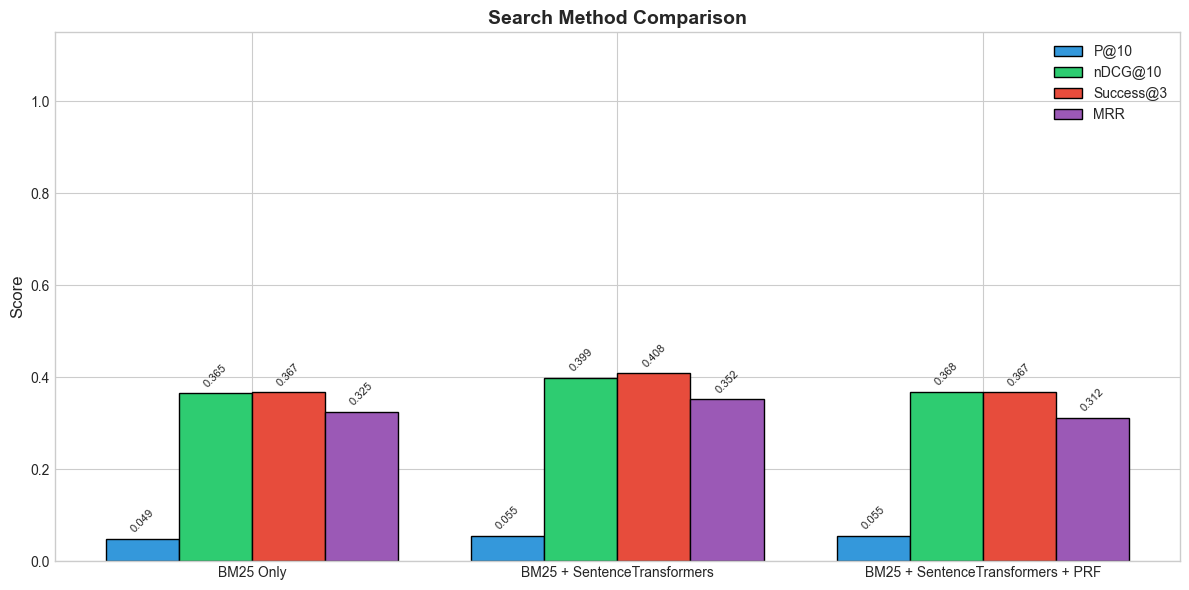

In [35]:
# Plot evaluation results as bar graph
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

models = [r['Model'] for r in eval_results]
metrics = ['P@10', 'nDCG@10', 'Success@3', 'MRR']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

x = np.arange(len(models))
width = 0.2

for i, (metric, color) in enumerate(zip(metrics, colors)):
    values = [r[metric] for r in eval_results]
    bars = ax.bar(x + i * width - 1.5 * width, values, width, label=metric, color=color, edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=45)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Search Method Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(loc='upper right')
ax.set_ylim(0, 1.15)

plt.tight_layout()
plt.show()

In [43]:
search('kids of famous Disney villains go to a prep school with heroes’ children').head()

,movie_title,genre,synopsis,score
9,Descendants 3,"Action, Adventure, Drama, Back to top",The teenagers of Disney's most infamous villai...,0.975700
77,Conspiracy,"Action, Adventure, Comedy, Back to top",Everyday teen hero Kim Possible (Sadie Stanley...,0.808919
943,Menendez: Blood Brothers,"Comedy, Family, Fantasy, Back to top",A boy is the only family member without superp...,0.719456
13,Descendants 2,"Action, Adventure, Family, Back to top",When the pressure to be royally perfect become...,0.683562
2,Descendants,"Comedy, Family, Fantasy, Back to top","Ben, son of Belle and the once selfish Beast, ...",0.614688


In [44]:
search('teenagers audition for a school musical while balancing sports and friendships').head()

,movie_title,genre,synopsis,score
4,High School Musical,"Comedy, Drama, Family, Back to top",Troy Bolton and Gabriella Montez are two total...,1.000000
6596,The Pennsylvania Miners' Story,"Comedy, Romance, Back to top",Established entertainment columnist Parker (Ke...,0.727494
2800,Die Wanderhure,"Drama, War, Back to top",Strong friendship between students slowly turn...,0.685184
3068,October Kiss,"Comedy, Drama, Music, Back to top",A musical romantic comedy set at a mall and fo...,0.663650
3952,Winter Dragon,"Drama, Back to top","Music Teacher revolves around Alyson Daley, a ...",0.658454


In [46]:
search('cheerleader falls for a zombie boy in a school divided by humans and zombies').head()

,movie_title,genre,synopsis,score
1145,Was soll bloß aus dir werden,"Musical, Back to top",Zombies and Cheerleaders is a music-driven sit...,0.993995
6,Z-O-M-B-I-E-S,"Family, Musical, Romance, Back to top","Disney's ""ZOMBIES"" is a music and dance filled...",0.977832
2661,The Marriage Fool,"Action, Horror, Thriller, Back to top",Zombies come out at night and two families mus...,0.761787
3756,Ice Sculpture Christmas,"Animation, Action, Adventure, Back to top",The knd must find a way to stop grandfather fr...,0.757832
9367,Nuclear Family,"Comedy, Horror, Back to top",a fantastical film turns an entire town into z...,0.744546
